# Lightning: Word Count with Dask

## Objective

This notebook demonstrates word counting by:
1. Generating a file with 1,000,000 English words
2. Counting words using a straightforward sequential approach
3. Counting words using Dask and the MapReduce approach

Word count is a classic distributed computing example (the "Hello World" of MapReduce). This notebook teaches the MapReduce pattern and demonstrates the performance benefits of parallel processing.

## Learning Objectives

- Sequential vs parallel processing
- MapReduce pattern: Map → Shuffle → Reduce
- Dask Bag for text processing
- Performance comparison between approaches


In [18]:
import dask.bag as db
from collections import Counter
import random
import time
import os

# Optional: Start client with 10 CPUs for diagnostics
from dask.distributed import Client
client = Client()
client


/usr/local/Caskroom/miniforge/base/envs/dask-tutorial/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59452 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:59452/status,
Dashboard: http://127.0.0.1:59452/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59453,Workers: 5
Dashboard: http://127.0.0.1:59452/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:59466,Total threads: 2
Dashboard: http://127.0.0.1:59467/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:59456,


## Generating Test Data

To demonstrate the benefits of parallel processing, we need a large dataset. We'll generate a text file with 1,000,000 English words using a common word list and random sampling.


In [19]:
# Common English words for generating test data
common_words = [
    "the", "be", "to", "of", "and", "a", "in", "that", "have", "i",
    "it", "for", "not", "on", "with", "he", "as", "you", "do", "at",
    "this", "but", "his", "by", "from", "they", "we", "say", "her", "she",
    "or", "an", "will", "my", "one", "all", "would", "there", "their", "what",
    # Add more words to get variety
    "up", "out", "many", "then", "them", "these", "so", "some", "her", "would",
    "make", "like", "into", "him", "time", "has", "look", "two", "more", "write",
    "go", "see", "number", "no", "way", "could", "people", "my", "than", "first",
    "water", "been", "call", "who", "oil", "sit", "now", "find", "down", "day",
    "did", "get", "come", "made", "may", "part", "over", "new", "sound", "take",
    "only", "little", "work", "know", "place", "year", "live", "me", "back", "give",
    "most", "very", "after", "thing", "our", "just", "name", "good", "sentence", "man",
    "think", "say", "great", "where", "help", "through", "much", "before", "line", "right",
    "too", "mean", "old", "any", "same", "tell", "boy", "follow", "came", "want",
    "show", "also", "around", "form", "three", "small", "set", "put", "end", "does",
    "another", "well", "large", "must", "big", "even", "such", "because", "turn", "here",
    "why", "ask", "went", "men", "read", "need", "land", "different", "home", "us",
    "move", "try", "kind", "hand", "picture", "again", "change", "off", "play", "spell",
    "air", "away", "animal", "house", "point", "page", "letter", "mother", "answer", "found",
    "study", "still", "learn", "should", "America", "world", "high", "every", "near", "add",
    "food", "between", "own", "below", "country", "plant", "last", "school", "father", "keep",
    "tree", "never", "start", "city", "earth", "eye", "light", "thought", "head", "under",
    "story", "saw", "left", "don't", "few", "while", "along", "might", "close", "something",
    "seem", "next", "hard", "open", "example", "begin", "life", "always", "those", "both",
    "paper", "together", "got", "group", "often", "run", "important", "until", "children", "side",
    "feet", "car", "mile", "night", "walk", "white", "sea", "began", "grow", "took",
    "river", "four", "carry", "state", "once", "book", "hear", "stop", "without", "second",
    "later", "miss", "idea", "enough", "eat", "face", "watch", "far", "Indian", "really",
    "almost", "let", "above", "girl", "sometimes", "mountain", "cut", "young", "talk", "soon",
    "list", "song", "leave", "family", "it's"
]

print(f"Word list contains {len(common_words)} unique words")


Word list contains 285 unique words


In [20]:
# Generate 1,000,000 words
num_words = 1_000_000
output_file = "words_1million.txt"

print(f"Generating {num_words:,} words...")
words = [random.choice(common_words) for _ in range(num_words)]

# Save to file (one word per line, or space-separated)
with open(output_file, 'w') as f:
    # Write words in chunks (e.g., 100 words per line for readability)
    words_per_line = 100
    for i in range(0, len(words), words_per_line):
        line = ' '.join(words[i:i+words_per_line])
        f.write(line + '\n')

file_size = os.path.getsize(output_file)
print(f"File created: {output_file}")
print(f"File size: {file_size:,} bytes ({file_size / 1024 / 1024:.2f} MB)")
print(f"Number of lines: {len(words) // words_per_line}")


Generating 1,000,000 words...
File created: words_1million.txt
File size: 5,211,167 bytes (4.97 MB)
Number of lines: 10000


## Sequential Word Count

The most straightforward approach: read the file, split into words, and count. This is simple and easy to understand, but it's single-threaded and processes one word at a time.


In [21]:
# Sequential word count
print("Counting words sequentially...")
start_time = time.time()

word_counts = {}
with open(output_file, 'r') as f:
    for line in f:
        words = line.strip().split()
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1

sequential_time = time.time() - start_time

# Display results
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
print(f"\nSequential counting completed in {sequential_time:.2f} seconds")
print(f"Total unique words: {len(word_counts)}")
print(f"Total word count: {sum(word_counts.values()):,}")
print("\nTop 10 most frequent words:")
for word, count in sorted_counts[:10]:
    print(f"  {word}: {count:,}")


Counting words sequentially...

Sequential counting completed in 0.15 seconds
Total unique words: 281
Total word count: 1,000,000

Top 10 most frequent words:
  her: 7,108
  my: 7,020
  would: 6,997
  say: 6,968
  picture: 3,673
  idea: 3,665
  always: 3,646
  get: 3,644
  take: 3,642
  try: 3,633


In [22]:
# Alternative: Using Counter (also sequential but more Pythonic)
print("Counting words using Counter...")
start_time = time.time()

word_counts_counter = Counter()
with open(output_file, 'r') as f:
    for line in f:
        words = line.strip().split()
        word_counts_counter.update(words)

counter_time = time.time() - start_time

print(f"Counter approach completed in {counter_time:.2f} seconds")
print(f"Top 10 most frequent words:")
for word, count in word_counts_counter.most_common(10):
    print(f"  {word}: {count:,}")


Counting words using Counter...
Counter approach completed in 0.10 seconds
Top 10 most frequent words:
  her: 7,108
  my: 7,020
  would: 6,997
  say: 6,968
  picture: 3,673
  idea: 3,665
  always: 3,646
  get: 3,644
  take: 3,642
  try: 3,633


## Dask MapReduce Word Count

The MapReduce pattern is a fundamental distributed computing concept:
- **Map**: Transform data (split text into words)
- **Shuffle**: Group by key (words)
- **Reduce**: Aggregate (count occurrences)

Dask Bag handles this automatically with parallel processing across partitions. This approach can process large files that don't fit in memory.


In [23]:
# Dask Bag word count (MapReduce)
print("Counting words with Dask (MapReduce)...")
start_time = time.time()

# Read text file with Dask Bag
bag = db.read_text(output_file)

# Map: Split into words
words = bag.str.split().flatten()

# Reduce: Count frequencies
word_counts_dask = words.frequencies()

# Compute (triggers execution)
result = word_counts_dask.compute()

dask_time = time.time() - start_time

# Display results
sorted_dask = sorted(result, key=lambda x: x[1], reverse=True)
print(f"\nDask counting completed in {dask_time:.2f} seconds")
print(f"Total unique words: {len(result)}")
print(f"Total word count: {sum(count for _, count in result):,}")
print("\nTop 10 most frequent words:")
for word, count in sorted_dask[:10]:
    print(f"  {word}: {count:,}")


Counting words with Dask (MapReduce)...

Dask counting completed in 0.13 seconds
Total unique words: 281
Total word count: 1,000,000

Top 10 most frequent words:
  her: 7,108
  my: 7,020
  would: 6,997
  say: 6,968
  picture: 3,673
  idea: 3,665
  always: 3,646
  get: 3,644
  take: 3,642
  try: 3,633


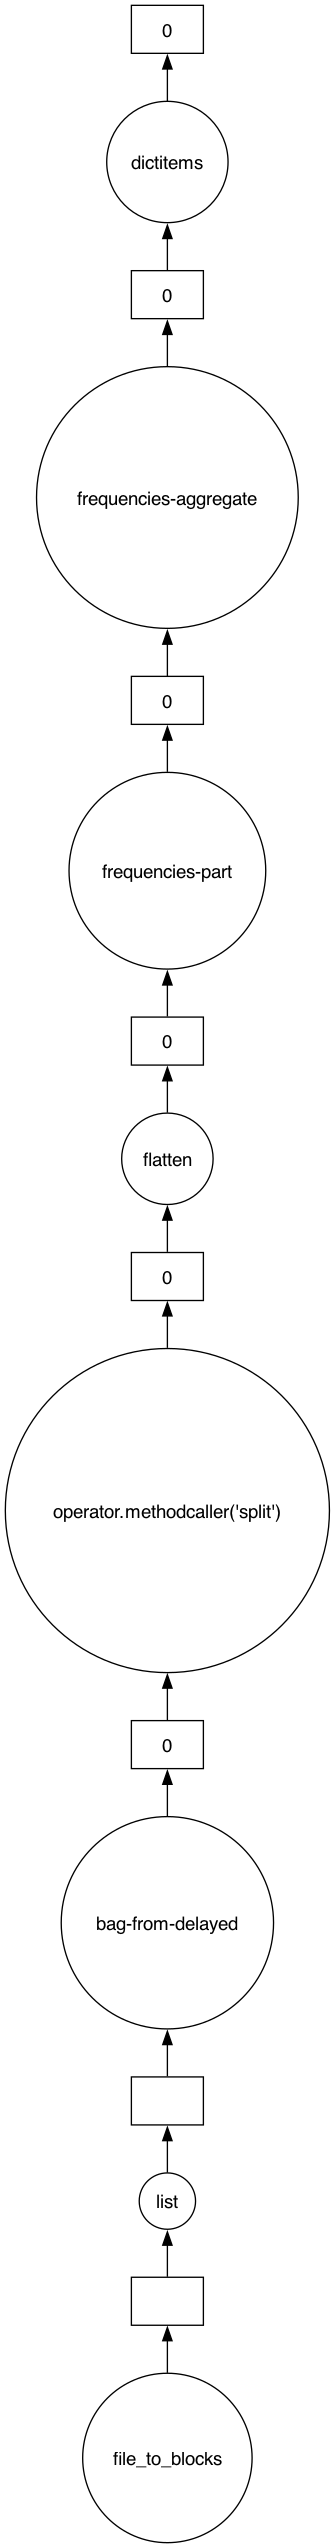

In [24]:
# Show the computation graph
# Recreate the computation graph for visualization
bag_viz = db.read_text(output_file)
words_viz = bag_viz.str.split().flatten()
word_counts_viz = words_viz.frequencies()
word_counts_viz.visualize()


In [25]:
# Inspect how Dask partitions the data
bag = db.read_text(output_file)
print(f"Number of partitions: {bag.npartitions}")
print(f"Note: Dask automatically partitions the file for parallel processing")
print(f"Each partition can be processed independently by different workers")

# Show the computation plan
words = bag.str.split().flatten()
word_counts_dask = words.frequencies()
print("\nComputation graph structure:")
print(word_counts_dask)


Number of partitions: 1
Note: Dask automatically partitions the file for parallel processing
Each partition can be processed independently by different workers

Computation graph structure:
dask.bag<dictitems, npartitions=1>


## Performance Comparison

Let's compare the execution times and verify that all approaches produce the same results. We'll also discuss when to use sequential vs parallel approaches and memory considerations.


In [26]:
# Compare performance
print("=" * 50)
print("PERFORMANCE COMPARISON")
print("=" * 50)
print(f"Sequential approach: {sequential_time:.2f} seconds")
print(f"Counter approach:   {counter_time:.2f} seconds")
print(f"Dask approach:      {dask_time:.2f} seconds")
print()

if sequential_time > 0:
    speedup = sequential_time / dask_time
    print(f"Speedup: {speedup:.2f}x")

# Verify results match
sequential_dict = dict(sorted_counts)
dask_dict = dict(sorted_dask)

if sequential_dict == dask_dict:
    print("\n✓ Results match perfectly!")
else:
    print("\n⚠ Results differ (this shouldn't happen)")
    print(f"Sequential unique words: {len(sequential_dict)}")
    print(f"Dask unique words: {len(dask_dict)}")


PERFORMANCE COMPARISON
Sequential approach: 0.15 seconds
Counter approach:   0.10 seconds
Dask approach:      0.13 seconds

Speedup: 1.14x

✓ Results match perfectly!


In [27]:
# Memory considerations
bag_for_info = db.read_text(output_file)
print("\nMemory considerations:")
print("- Sequential: Loads entire file into memory (or processes line by line)")
print("- Dask: Processes in partitions, can handle files larger than memory")
print(f"- File size: {file_size / 1024 / 1024:.2f} MB")
print(f"- Dask partitions: {bag_for_info.npartitions}")



Memory considerations:
- Sequential: Loads entire file into memory (or processes line by line)
- Dask: Processes in partitions, can handle files larger than memory
- File size: 4.97 MB
- Dask partitions: 1


## Summary

### Key Takeaways

- **Sequential Approach**: Simple, straightforward, single-threaded. Best for small files or when simplicity is more important than speed.

- **Dask MapReduce**: Parallel, scalable, handles large files. Best for large datasets where parallel processing provides significant speedup.

- **MapReduce Pattern**: 
  - **Map**: Transform data (split text into words)
  - **Shuffle**: Group by key (words)
  - **Reduce**: Aggregate (count occurrences)

- **When to Use Each**:
  - Sequential: Small files, simple scripts, single-machine processing
  - Dask: Large files, distributed computing, files larger than memory

- **Dask Bag**: Perfect for text processing tasks, unstructured data, and parallel operations on text files.
